In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 93.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 79.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 91.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 96.0 MB/s eta 0:00:00t

In [332]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler as sc
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler as sc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [465]:
#Importing the dataset
df = pd.read_csv("https://minio.lab.sspcloud.fr/jbrablx/ai_insurance/raw/train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [390]:
df.shape

(381109, 12)

In [391]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [392]:
#Creating Bins
age=pd.cut(df['Age'],bins=5,labels=['A1','A2','A3','A4','A5'])
rc=pd.cut(df['Region_Code'],bins=5,labels=['A1','A2','A3','A4','A5'])
ap=pd.cut(df['Annual_Premium'],bins=5,labels=['A1','A2','A3','A4','A5'])
vin=pd.cut(df['Vintage'],bins=5,labels=['A1','A2','A3','A4','A5'])

In [322]:
#Adding columns to our dataset
df['age']=age             
df['rc']=rc 
df['ap']=ap
df['vin']=vin

In [323]:
#Creating dummy columns
# df_dum=pd.get_dummies(df[['age','rc','ap','vin','Gender','Vehicle_Age','Vehicle_Damage','Vehicle_Damage']])

In [324]:
# df=pd.concat([df,df_dum],axis=1)

In [87]:
# df.drop(['Gender','Age','age','Region_Code','rc','Vehicle_Age','Vehicle_Damage','Annual_Premium','ap','Vintage','vin'],axis=1,inplace=True)

# Preprocessing

In [466]:
df = df.replace({'Gender': {'Male': 0, 'Female': 1}, 'Vehicle_Age': {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},
            'Vehicle_Damage': {'Yes': 1, 'No': 0}})

/tmp/ipykernel_301/1536672616.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Gender': {'Male': 0, 'Female': 1}, 'Vehicle_Age': {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},


In [394]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [467]:
#Deleting of unneeded variables
df.drop(['id','Region_Code','Policy_Sales_Channel'], axis=1, inplace=True)

In [468]:
#Dividing the data into inputs and output
X = df.loc[:, df.columns != 'Response']
Y = df['Response']

In [469]:
#Dividing the data for train and test
X_train, X_test, Y_train, y_test = train_test_split(X.values, Y.values, test_size=0.1, random_state=42)

In [470]:
#Scaling the data using the sklearn StandardScaler to set the mean to 0 and standard deviation to 1.
scaler=sc()
scaled_df_train=scaler.fit_transform(X_train)
scaled_df_test=scaler.fit_transform(X_test)

In [471]:
#Dividing train data
X_train, X_val, y_train, y_val = train_test_split(scaled_df_train, Y_train, test_size=0.15, random_state=42)

In [455]:
X_train[0:5, :]

array([[-0.92179387,  1.0435359 ,  0.04662429, -0.91993958,  0.68721   ,
         0.99025154, -1.62449843,  0.55785943],
       [ 1.08484124,  1.55955437,  0.04662429, -0.91993958,  0.68721   ,
         0.99025154,  0.95404435,  1.05992668],
       [ 1.08484124, -0.05300334,  0.04662429,  1.08702791,  0.68721   ,
        -1.00984443, -1.62449843, -0.29087331],
       [-0.92179387,  0.14050358,  0.04662429, -0.91993958,  2.44864459,
         0.99025154,  0.78034717,  0.6415373 ],
       [-0.92179387,  1.81756361,  0.04662429,  1.08702791,  0.68721   ,
        -1.00984443,  0.52509138,  1.52613199]])

# Stochastic Gradient Descent Classifier

**SGDClassifier**, which stands for Stochastic Gradient Descent Classifier, is a linear classifier that uses stochastic gradient descent (SGD) as its optimization algorithm. It's a part of scikit-learn machine learning library. It uses *stochastic gradient descent*, which is an iterative optimization algorithm. SGD updates the model parameters based on the gradient of the loss function with respect to the parameters. It processes one training example at a time, making it particularly useful for large datasets. SGDClassifier is often used for linear classification tasks, where the decision boundary is a linear combination of the input features. You can specify different loss functions based on the type of classification problem you are working on. Common choices include 'hinge' (for linear SVM), 'log' (for logistic regression), and 'modified_huber' (a smooth approximation of the hinge loss). It supports L1 and L2 regularization, which helps prevent overfitting by penalizing large coefficients. Due to its stochastic nature, SGD is suitable for large datasets, as it processes one example at a time rather than the entire dataset.

In [456]:
#Selecting the right model with tuned Hyper-Parameters
sgc=SGDClassifier(penalty='l1',loss='modified_huber',early_stopping=True)
model_params={'alpha':[0.0012,0.0011,0.0013],
              'learning_rate':['invscaling'],
              'max_iter':[690,700,710],
              'validation_fraction':[0.46,0.47,0.48],
              'eta0':[0.65,0.66,0.64]}
ran=RandomizedSearchCV(sgc,param_distributions=model_params,cv=5,n_jobs=-1,verbose=2,n_iter=100)

In [457]:
ran.fit(scaled_df_train, Y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/mamba/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True,
                                           loss='modified_huber',
                                           penalty='l1'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.0012, 0.0011, 0.0013],
                                        'eta0': [0.65, 0.66, 0.64],
                                        'learning_rate': ['invscaling'],
                                        'max_iter': [690, 700, 710],
                                        'validation_fraction': [0.46, 0.47,
                                                                0.48]},
                   verbose=2)

In [458]:
ran.best_params_

{'validation_fraction': 0.47,
 'max_iter': 700,
 'learning_rate': 'invscaling',
 'eta0': 0.66,
 'alpha': 0.0012}

In [459]:
ran.best_score_

0.8777689666616615

In [472]:
#Prediction 
y_pred=ran.predict(scaled_df_test)

In [473]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%% \n" % (accuracy * 100.0))

TypeError: 'numpy.float64' object is not callable

Accuracy can be misleading when the number of positive and negative examples is significantly different, as it can be raised simply by predicting the majority class all the time.

In [474]:
# Confusion matrix
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

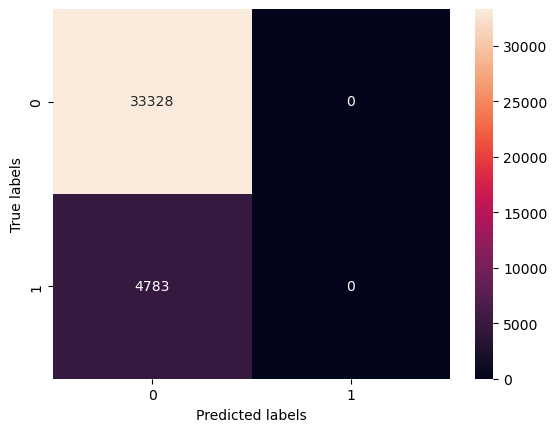

In [475]:
plot_confusion_matrix(y_test, y_pred)

If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case, we have no false and true positives, it could be acceptable. However, we need to decrease as much as possible the false negative responses (4776 cases) because they refer to the customers that want an auto subscription while the model flagged them as customers that don't want the auto insurance.

# Stochastic Gradient Descent Classifier with class weight

**CLASS WEIGHT**

The goal is to identify the customers interested in auto insurance, but we don't have many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We will do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [476]:
neg, pos = np.bincount(Y_train)
print(pos,neg)

41927 301071


In [477]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all stays the same.
weight_for_0 = (1 / neg)*(neg+pos)/2.0 
weight_for_1 = (1 / pos)*(neg+pos)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}\n'.format(weight_for_0),
      'Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
 Weight for class 1: 4.09


In [478]:
#Selecting the right model with tuned Hyper-Parameters and class weights
sgc_weighted=SGDClassifier(penalty='l1',loss='modified_huber',early_stopping=True, class_weight=class_weights)
model_params={'alpha':[0.0012,0.0011,0.0013],
              'learning_rate':['invscaling'],
              'max_iter':[690,700,710],
              'validation_fraction':[0.46,0.47,0.48],
              'eta0':[0.65,0.66,0.64]}
ran=RandomizedSearchCV(sgc_weighted,param_distributions=model_params,cv=5,n_jobs=-1,verbose=2,n_iter=100)

In [479]:
ran.fit(scaled_df_train, Y_train)

/opt/mamba/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(class_weight={0: 0.5696297551075992,
                                                         1: 4.090419061702483},
                                           early_stopping=True,
                                           loss='modified_huber',
                                           penalty='l1'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.0012, 0.0011, 0.0013],
                                        'eta0': [0.65, 0.66, 0.64],
                                        'learning_rate': ['invscaling'],
                                        'max_iter': [690, 700, 710],
                                        'validation_fraction': [0.46, 0.47,
                                                                0.48]},
                   verbose=2)

In [347]:
ran.best_params_

{'validation_fraction': 0.48,
 'max_iter': 700,
 'learning_rate': 'invscaling',
 'eta0': 0.65,
 'alpha': 0.0011}

In [348]:
ran.best_score_

0.6397325877941

In [480]:
y_weight_pred=ran.predict(scaled_df_test)

In [481]:
weight_accuracy = accuracy_score(y_test, y_weight_pred)
print("Accuracy: %.2f%% \n" % (weight_accuracy * 100.0))

Accuracy: 64.18% 



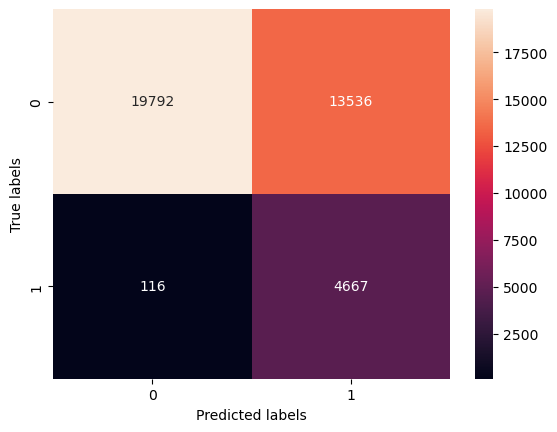

In [482]:
plot_confusion_matrix(y_test, y_weight_pred)

In this case, the number of false negatives dropped considerably from 4783 to 116 cases.

# Fully connected Neural Network

**A Fully Connected Neural Network**, also known as a **Dense Neural Network** or **a Feedforward Neural Network**, is a type of artificial neural network where each neuron in one layer is connected to every neuron in the next layer.

In [533]:
#Defining the model
model = keras.models.Sequential() #Creates a sequential model, which is a linear stack of layers.
model.add(keras.Input(shape=(8,))) #Adds an input layer to the model with an input form of (8,).
model.add(keras.layers.Dense(256, activation='relu')) #Adds a dense layer with 128 neurons and a ReLU activation function.
model.add(keras.layers.Dense(128, activation='relu')) #Adds a second dense layer with 128 neurons and a ReLU activation function.
model.add(keras.layers.Dense(32, activation='relu')) #Adds a third dense layer with 32 neurons and a ReLU activation function.

model.add(keras.layers.Dense(1, activation='sigmoid')) #Add an output layer with 1 neuron and a sigmoid activation function.

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
#Displays a summary of the model
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,361 (153.75 KB)

 Trainable params: 39,361 (153.75 KB)

 Non-trainable params: 0 (0.00 B)

In [534]:
#Number of iterations
epochs = 10

In [535]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6126 - loss: 0.5677 - val_accuracy: 0.6473 - val_loss: 0.4877
Epoch 2/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6483 - loss: 0.4413 - val_accuracy: 0.6556 - val_loss: 0.4914
Epoch 3/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6637 - loss: 0.4359 - val_accuracy: 0.6691 - val_loss: 0.4810
Epoch 4/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6688 - loss: 0.4363 - val_accuracy: 0.6810 - val_loss: 0.4706
Epoch 5/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6751 - loss: 0.4327 - val_accuracy: 0.6775 - val_loss: 0.4779
Epoch 6/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6749 - loss: 0.4340 - val_accuracy: 0.6831 - val_loss: 0.4777
Epoch 7/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6778 - loss: 0.4351 - val_accuracy: 0.6833 - val_loss: 0.4753
Epoch 8/10
9111/9111 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6799 - loss: 0

In [536]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

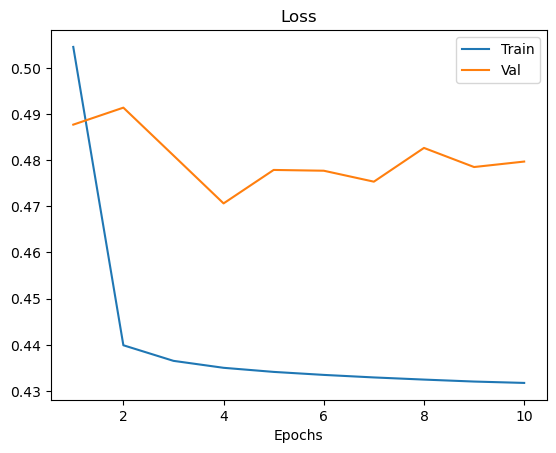

In [537]:
plt.figure()
plt.plot(np.arange(1, epochs+1), train_loss)
plt.plot(np.arange(1, epochs+1), val_loss)
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend(['Train', 'Val'])
plt.show()

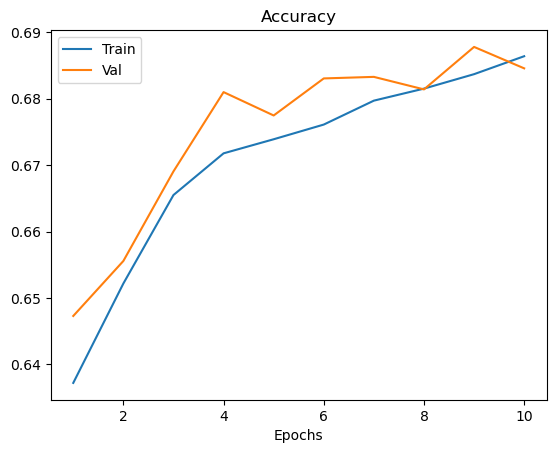

In [538]:
plt.figure()
plt.plot(np.arange(1, epochs+1), train_acc)
plt.plot(np.arange(1, epochs+1), val_acc)
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [539]:
y_pred=model.predict(scaled_df_test)

1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step


In [549]:
# Prediction is a numpy array containing probability predictions
threshold = 0.3 
# Applying threshold to convert probabilities into binary values
y_binary_pred = np.where(y_pred >= threshold, 1, 0)

In [550]:
accuracy = accuracy_score(y_test, y_binary_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.97%


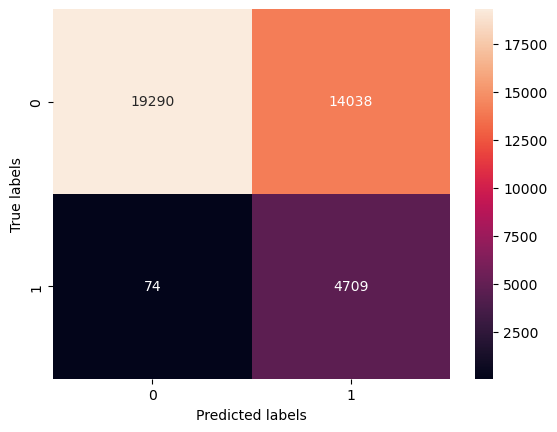

In [551]:
plot_confusion_matrix(y_test, y_binary_pred)